In [9]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from churn_opt.data import load_telco_csv
from churn_opt.features import add_features
from churn_opt.experiment import run_one_model

sns.set_theme()
plt.rcParams["figure.figsize"] = (9, 5)


In [10]:
df = load_telco_csv("C:/Users/Burakk/Desktop/churn-optimization/data/raw/Telco-Customer-Churn.csv")
df = add_features(df)

if "TotalCharges" in df.columns:
    df = df.drop(columns=["TotalCharges"])

train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Churn"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.25, stratify=train_df["Churn"], random_state=42)

(train_df.shape, val_df.shape, test_df.shape)


((4225, 23), (1409, 23), (1409, 23))

In [11]:
res_lr = run_one_model(
    model_type="lr",
    train_df=train_df, val_df=val_df, test_df=test_df,
    do_calibration=True,
    calibration_method="sigmoid",
    random_state=42
)

res_hgb = run_one_model(
    model_type="hgb",
    train_df=train_df, val_df=val_df, test_df=test_df,
    do_calibration=True,
    calibration_method="sigmoid",
    random_state=42
)

res_lr.head(), res_hgb.head()



MODEL: LR | calibration=True (sigmoid)

[VAL] ROC-AUC=0.8434 | PR-AUC=0.6484 | Brier=0.1360

[TEST] ROC-AUC=0.8413 | PR-AUC=0.6527 | Brier=0.1372

--- WORST | VAL Top-K grid (by SCORE) ---
   k    profit  target_rate
0.01  -63.2115     0.009936
0.03 -187.6275     0.029808
0.05 -324.6045     0.049681
0.10 -665.8355     0.100071

--- WORST | TEST Top-K grid (by SCORE) ---
   k    profit  target_rate
0.01  -63.0060     0.009936
0.03 -178.9710     0.029808
0.05 -307.8325     0.049681
0.10 -651.2590     0.100071

--- BASE | VAL Top-K grid (by SCORE) ---
   k   profit  target_rate
0.10 1946.116     0.100071
0.05  912.840     0.049681
0.03  583.376     0.029808
0.01  279.472     0.009936

--- BASE | TEST Top-K grid (by SCORE) ---
   k   profit  target_rate
0.10 1893.574     0.100071
0.05 1084.404     0.049681
0.03  726.080     0.029808
0.01  334.622     0.009936

--- BEST | VAL Top-K grid (by SCORE) ---
   k    profit  target_rate
0.10 18755.898     0.100071
0.05  9691.974     0.049681
0.03 

(  scenario           policy  val_choice  val_profit  test_profit  \
 4     base  score_threshold     0.52859    3238.678     2675.908   
 5     base       score_topk     0.10000    1946.116     1893.574   
 6     base        call_none         NaN         NaN        0.000   
 7     base         call_all         NaN         NaN    -4997.088   
 8     best  score_threshold     0.60470   51452.400    49072.098   
 
    target_rate_test  
 4          0.256920  
 5          0.100071  
 6          0.000000  
 7          1.000000  
 8          0.758694  ,
    scenario           policy  val_choice  val_profit  test_profit  \
 4      base  score_threshold    1.002375    7184.794     2192.854   
 5      base       score_topk    0.100000    3500.786     1583.308   
 6      base        call_none         NaN         NaN        0.000   
 7      base         call_all         NaN         NaN    -4997.088   
 11     best         call_all         NaN         NaN    47948.040   
 
     target_rate_test  

In [12]:
def best_policy_per_scenario(res: pd.DataFrame) -> pd.DataFrame:
    best = (res.sort_values(["scenario", "test_profit"], ascending=[True, False])
              .groupby("scenario")
              .head(1)
              .reset_index(drop=True))
    return best[["scenario", "policy", "val_choice", "test_profit", "target_rate_test"]]

best_lr = best_policy_per_scenario(res_lr).assign(model="LR")
best_hgb = best_policy_per_scenario(res_hgb).assign(model="HGB")

best_compare = pd.concat([best_lr, best_hgb], ignore_index=True)
best_compare.sort_values(["scenario", "model"])


,scenario,policy,val_choice,test_profit,target_rate_test,model
3,base,score_threshold,1.002375,2192.854,0.230660,HGB
0,base,score_threshold,0.528590,2675.908,0.256920,LR
4,best,call_all,NaN,47948.040,1.000000,HGB
1,best,score_threshold,0.604700,49072.098,0.758694,LR
5,worst,score_threshold,0.000000,0.000,0.000000,HGB
2,worst,score_threshold,0.000000,0.000,0.000000,LR


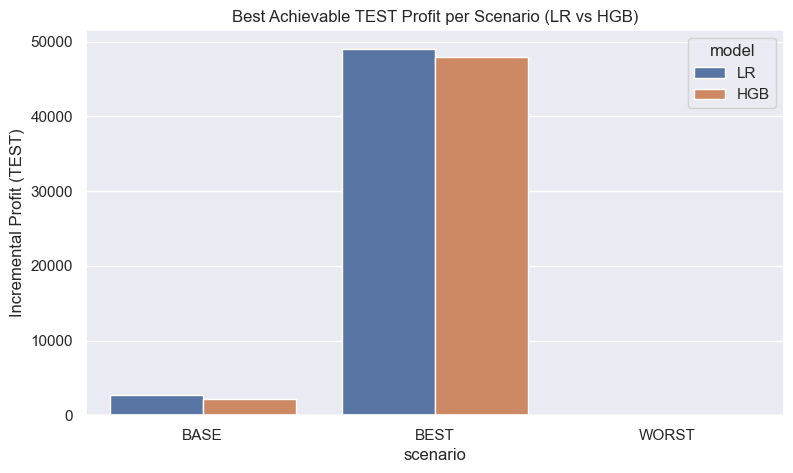

In [13]:
plot_df = best_compare.copy()
plot_df["scenario"] = plot_df["scenario"].str.upper()

sns.barplot(data=plot_df, x="scenario", y="test_profit", hue="model")
plt.axhline(0, color="black", linewidth=1)
plt.title("Best Achievable TEST Profit per Scenario (LR vs HGB)")
plt.ylabel("Incremental Profit (TEST)")
plt.show()


In [14]:
# Choose final model by higher profit in base/best AND stability
# (You can justify LR as your final choice even if some scenario ties.)
final_model = "LR"

final_table = best_lr.copy()
final_table["final_model"] = final_model

# Make it more presentation-friendly
final_table = final_table.rename(columns={
    "policy": "recommended_policy",
    "val_choice": "decision_parameter",
    "test_profit": "expected_test_profit",
    "target_rate_test": "expected_target_rate"
})

final_table


,scenario,recommended_policy,decision_parameter,expected_test_profit,expected_target_rate,model,final_model
0,base,score_threshold,0.52859,2675.908,0.256920,LR,LR
1,best,score_threshold,0.60470,49072.098,0.758694,LR,LR
2,worst,score_threshold,0.00000,0.000,0.000000,LR,LR


In [15]:
res_lr.to_csv("C:/Users/Burakk/Desktop/churn-optimization/outputs/tables/results_lr.csv", index=False)
res_hgb.to_csv("C:/Users/Burakk/Desktop/churn-optimization/outputs/tables/results_hgb.csv", index=False)
best_compare.to_csv("C:/Users/Burakk/Desktop/churn-optimization/outputs/tables/best_policy_compare.csv", index=False)
final_table.to_csv("C:/Users/Burakk/Desktop/churn-optimization/outputs/tables/final_recommendation.csv", index=False)

print("Saved tables to outputs/tables/")


Saved tables to outputs/tables/


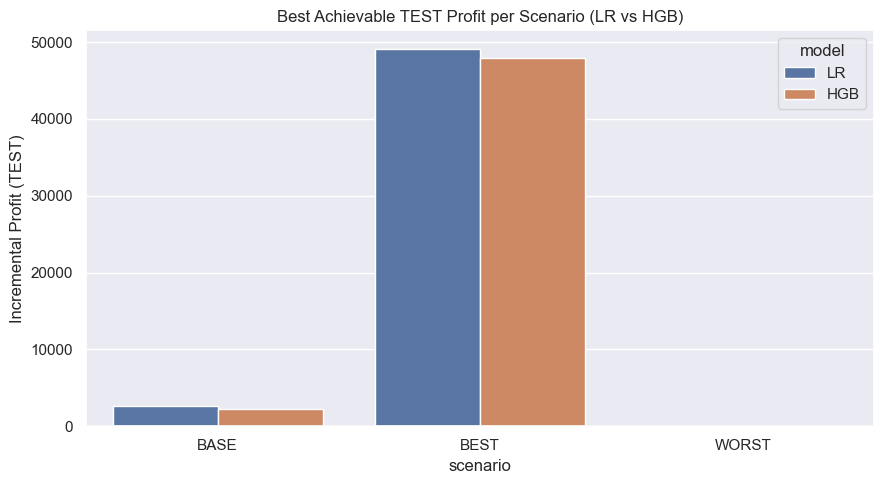

Saved figure to outputs/figures/


In [16]:
Path("C:/Users/Burakk/Desktop/churn-optimization/outputs/figures").mkdir(parents=True, exist_ok=True)

plt.figure()
sns.barplot(data=plot_df, x="scenario", y="test_profit", hue="model")
plt.axhline(0, color="black", linewidth=1)
plt.title("Best Achievable TEST Profit per Scenario (LR vs HGB)")
plt.ylabel("Incremental Profit (TEST)")
plt.tight_layout()
plt.savefig("../outputs/figures/best_profit_model_compare.png", dpi=150)
plt.show()

print("Saved figure to outputs/figures/")


Final model: Calibrated Logistic Regression (sigmoid)

Final decision policy: Profit score threshold (scenario-adaptive targeting)

Worst-case scenario: Do not run retention interventions (call_none)

Base-case scenario: Apply score-threshold targeting (moderate targeting rate; avoids call_all)

Best-case scenario: Apply score-threshold targeting (higher targeting rate; still more efficient than blanket campaigns)